### Program 1

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load the IMDB dataset
df = pd.read_csv("/content/IMDB Dataset.csv")

In [ ]:
# Preview first few rows
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Info about dataset
print("Loaded dataset size:", len(df))
print("Columns:", df.columns)
df['sentiment'].value_counts()

Loaded dataset size: 50000
Columns: Index(['review', 'sentiment'], dtype='object')


,count
sentiment,
positive,25000
negative,25000


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


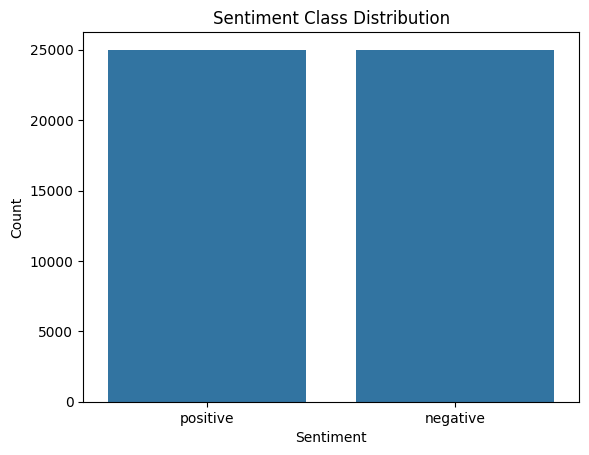

In [ ]:
# Display class distribution
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

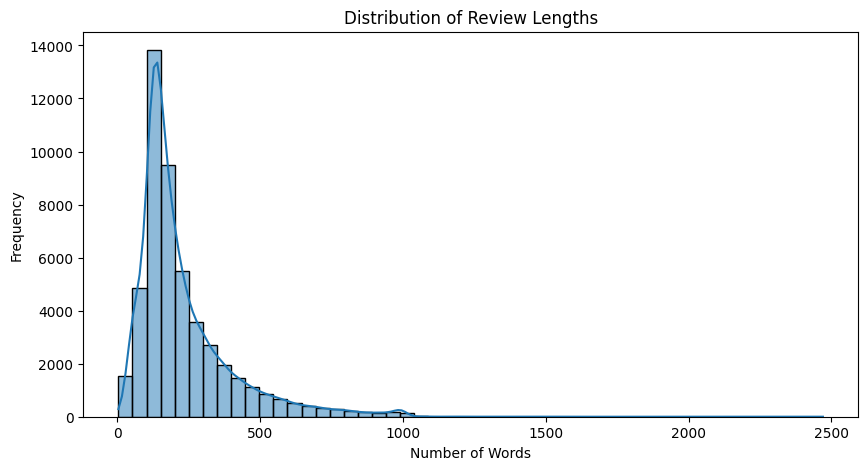

In [ ]:
# Add review length column
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

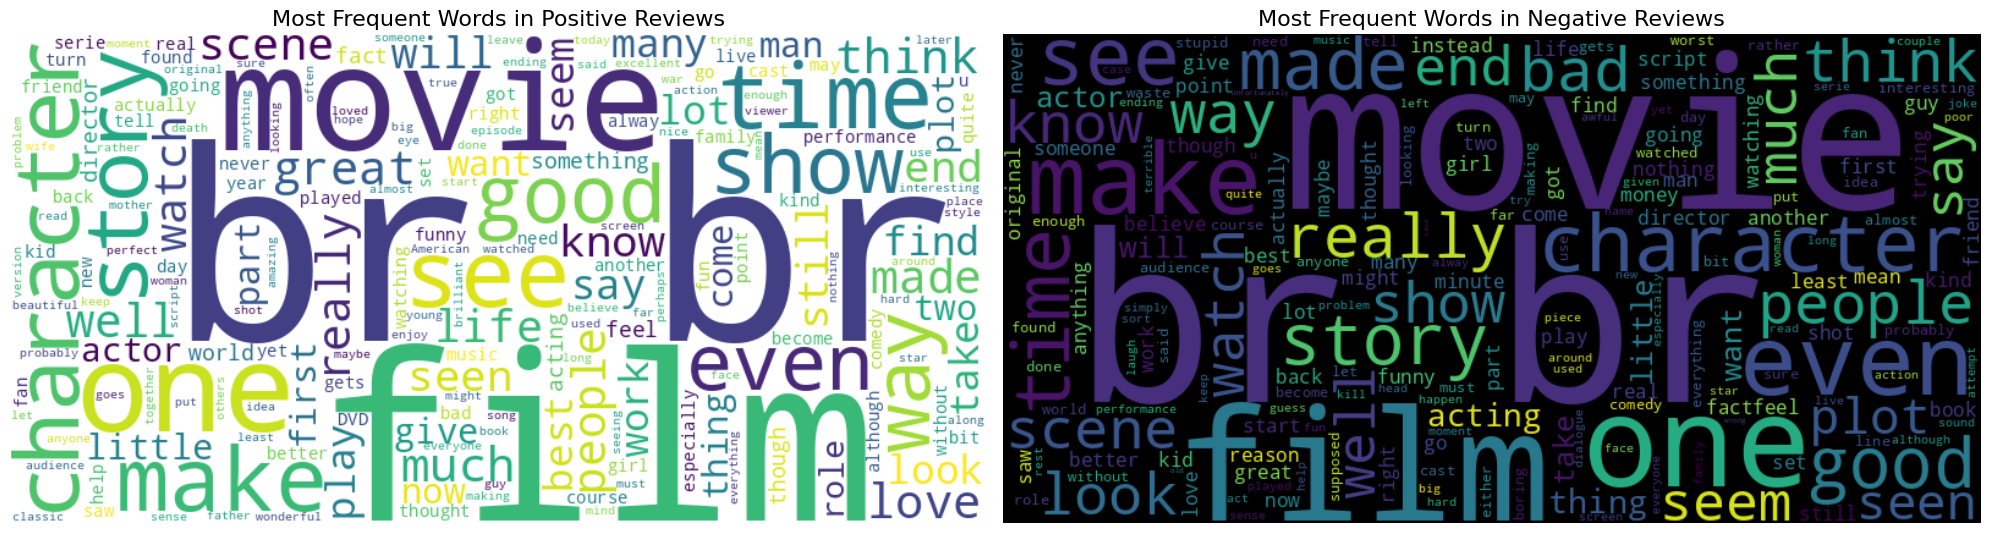

In [ ]:
# WordCloud for positive and negative reviews

# Prepare text
positive_text = " ".join(df[df['sentiment'] == 'positive']['review'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['review'])

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# Positive
axes[0].imshow(positive_wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Most Frequent Words in Positive Reviews", fontsize=16)

# Negative
axes[1].imshow(negative_wc, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Most Frequent Words in Negative Reviews", fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
# Clean text: remove HTML, punctuation, lowercase
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text.lower()

df['review'] = df['review'].apply(clean_text)

In [ ]:
# Encode labels (positive=1, negative=0)
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [ ]:
# Tokenization and padding
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['review'])

X = tokenizer.texts_to_sequences(df['review'])
X = pad_sequences(X, maxlen=max_len)
y = df['sentiment'].values

In [ ]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define RNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_shape=(max_len,)))
model.add(SimpleRNN(units=64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,321 (2.47 MB)

 Trainable params: 648,321 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6213 - loss: 0.6184 - val_accuracy: 0.8180 - val_loss: 0.4267
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8448 - loss: 0.3689 - val_accuracy: 0.8341 - val_loss: 0.3918
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8930 - loss: 0.2648 - val_accuracy: 0.8480 - val_loss: 0.4102
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9434 - loss: 0.1525 - val_accuracy: 0.8422 - val_loss: 0.4844
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9578 - loss: 0.1210 - val_accuracy: 0.8070 - val_loss: 0.6224
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8122 - loss: 0.6269

Test Accuracy: 0.8100


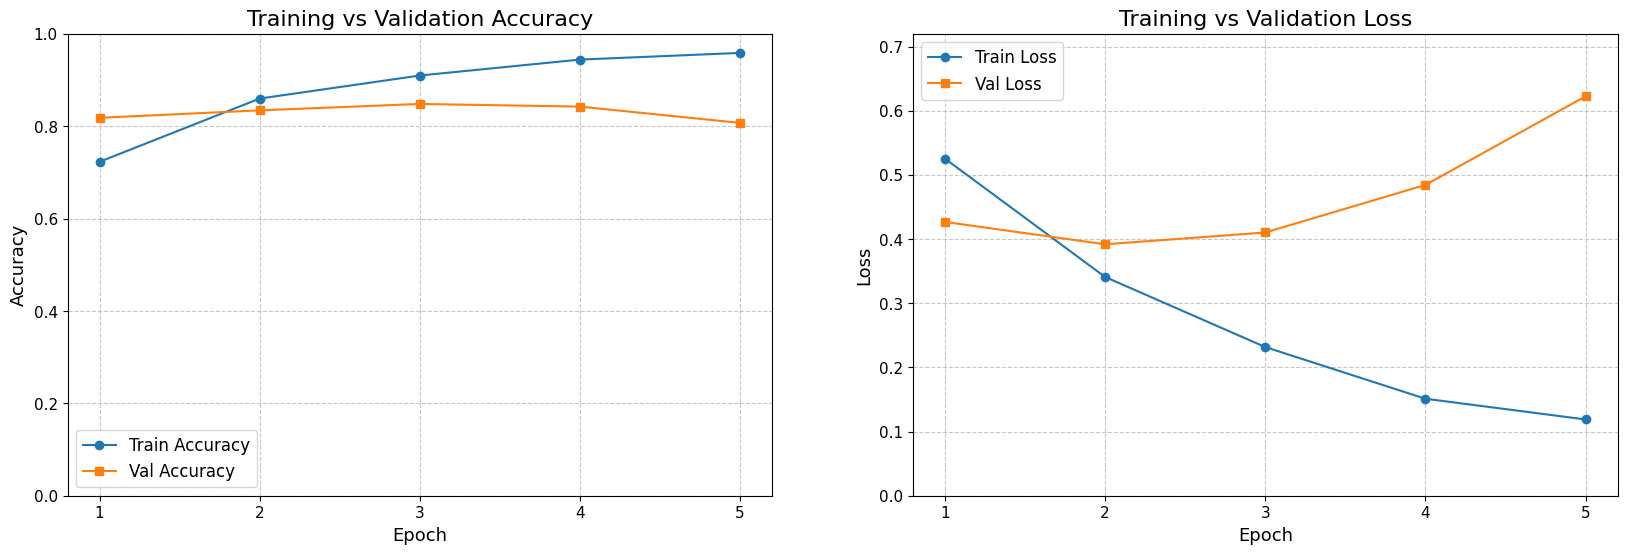

In [ ]:
# Plot accuracy and loss curves

# Define figure
plt.figure(figsize=(20, 6))

epochs_range = range(len(history.history['accuracy']))
epoch_labels = [str(i + 1) for i in epochs_range]

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='s', label='Val Accuracy')
plt.title('Training vs Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(ticks=epochs_range, labels=epoch_labels, fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 1.0)

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='s', label='Val Loss')
plt.title('Training vs Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(ticks=epochs_range, labels=epoch_labels, fontsize=11)
plt.yticks(fontsize=11)
max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
plt.ylim(0, round(max_loss + 0.1, 2))

# Show plot
plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report:

              precision    recall  f1-score   support

    Negative       0.90      0.69      0.78      4961
    Positive       0.75      0.93      0.83      5039

    accuracy                           0.81     10000
   macro avg       0.83      0.81      0.81     10000
weighted avg       0.83      0.81      0.81     10000



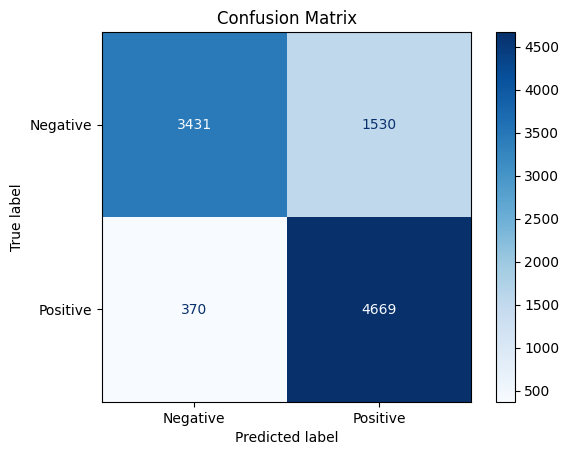

In [ ]:
# Predict and evaluate using confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


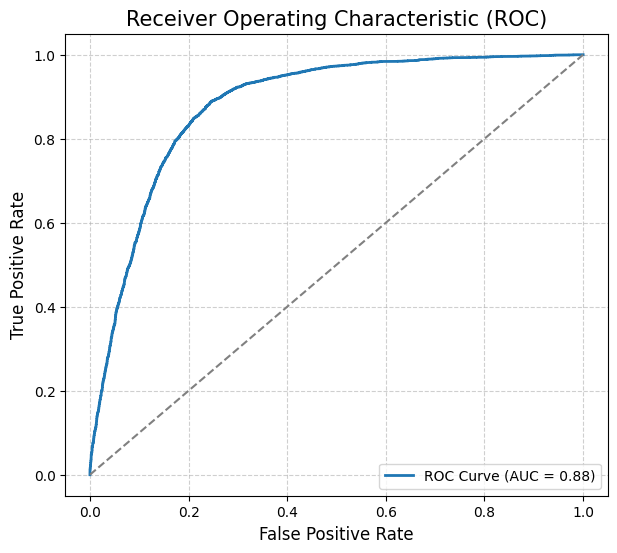

In [ ]:
# ROC Curve and AUC Score

from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Function to predict sentiment from raw review text
def predict_sentiment(text):
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=max_len)
    prob = model.predict(padded)[0][0]
    label = 'Positive' if prob > 0.5 else 'Negative'
    return label, prob

# Show predictions on 5 random test reviews
print("\nSample Predictions on Test Reviews:\n")
for i in range(5):
    idx = random.randint(0, len(X_test) - 1)
    raw_review = df.iloc[X_test.shape[0] + idx]['review']
    actual = 'Positive' if y_test[idx] == 1 else 'Negative'
    pred, prob = predict_sentiment(raw_review)
    print(f"Review #{i+1}:")
    print(f"Review Snippet: {raw_review[:200]}...")
    print(f"Actual: {actual} |Predicted: {pred} ({prob:.2f})\n")



Sample Predictions on Test Reviews:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Review #1:
Review Snippet: this was my first look at this short lived british tv horror series  but i had seen a couple of hammer horror films  horror of dracula  captain kronos  vampire hunter  and thought highly enough of the...
Actual: Negative |Predicted: Positive (0.99)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Review #2:
Review Snippet: this might be the poorest example of amateur propaganda ever made  the writers and producers should study the german films of the thirties and forties  they knew how to sell  even soviet style clunky ...
Actual: Negative |Predicted: Negative (0.19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Review #3:
Review Snippet: this miniseries is a reasonable sequel to the original gone with the wind  if one views this on its own merit  and not immediately following the original   it comes out pretty good  i am sure that mos...
Actual: Positive |Predicted: Positive (1.00)

1/1 ━━━━━━━━━━━━

### Program 2

In [ ]:
# Install required libraries
!pip install -q datasets transformers tensorflow scikit-learn matplotlib seaborn

In [ ]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import time

In [ ]:
# Fix randomness for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Load CSV
df = pd.read_csv("/content/aa_dataset-tickets-multi-lang-5-2-50-version.csv")

In [ ]:
# Preview first few rows
df.head()

,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Wesentlicher Sicherheitsvorfall,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die Meldung des kritischen Sic...,Incident,Technical Support,high,de,51,Security,Outage,Disruption,Data Breach,NaN,NaN,NaN,NaN
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...","Thank you for reaching out, <name>. We are awa...",Incident,Technical Support,high,en,51,Account,Disruption,Outage,IT,Tech Support,NaN,NaN,NaN
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Thank you for your inquiry. Our products suppo...,Request,Returns and Exchanges,medium,en,51,Product,Feature,Tech Support,NaN,NaN,NaN,NaN,NaN
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",We appreciate you reaching out with your billi...,Request,Billing and Payments,low,en,51,Billing,Payment,Account,Documentation,Feedback,NaN,NaN,NaN
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Thank you for your inquiry. Our product suppor...,Problem,Sales and Pre-Sales,medium,en,51,Product,Feature,Feedback,Tech Support,NaN,NaN,NaN,NaN


In [ ]:
# Info about dataset
print("Loaded dataset size:", len(df))
print("Columns:", df.columns)

Loaded dataset size: 28587
Columns: Index(['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language',
       'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6',
       'tag_7', 'tag_8'],
      dtype='object')


In [ ]:
# We'll use English rows only for a focused RNN classification
if 'language' in df.columns:
    df_en = df[df['language'] == 'en'].copy()
else:
    df_en = df.copy()

print("English subset size:", len(df_en))
display(df_en[['subject','body','type','queue','priority']].head())

English subset size: 16338


,subject,body,type,queue,priority
1,Account Disruption,"Dear Customer Support Team,\n\nI am writing to...",Incident,Technical Support,high
2,Query About Smart Home System Integration Feat...,"Dear Customer Support Team,\n\nI hope this mes...",Request,Returns and Exchanges,medium
3,Inquiry Regarding Invoice Details,"Dear Customer Support Team,\n\nI hope this mes...",Request,Billing and Payments,low
4,Question About Marketing Agency Software Compa...,"Dear Support Team,\n\nI hope this message reac...",Problem,Sales and Pre-Sales,medium
5,Feature Query,"Dear Customer Support,\n\nI hope this message ...",Request,Technical Support,high


In [ ]:
# Create the text input by concatenating subject and body (handle NaNs)
df_en['subject'] = df_en['subject'].fillna('')
df_en['body'] = df_en['body'].fillna('')
df_en['text'] = (df_en['subject'] + '. ' + df_en['body']).str.strip()

In [ ]:
# Target: 'type' column (categories to classify)
print("Unique 'type' values:", df_en['type'].unique())
df_en = df_en[df_en['type'].notna()]  # drop if missing type
labels = df_en['type'].astype(str)
le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Num classes:", num_classes)
print("Classes:", list(le.classes_))


Unique 'type' values: ['Incident' 'Request' 'Problem' 'Change']
Num classes: 4
Classes: ['Change', 'Incident', 'Problem', 'Request']


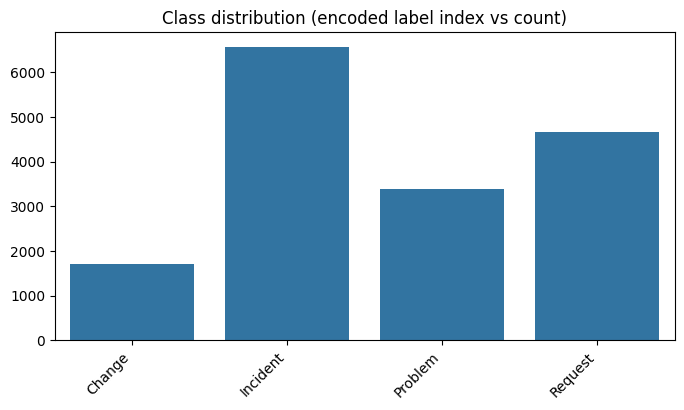

In [ ]:
# Quick EDA: class distribution
class_counts = pd.Series(y).value_counts().sort_index()
plt.figure(figsize=(8,4))
sns.barplot(x=[le.classes_[i] for i in class_counts.index], y=class_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Class distribution (encoded label index vs count)")
plt.show()

In [ ]:
# Train/test split (stratified)
X = df_en['text'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

print("Train size:", len(X_train), "Validation size:", len(X_val))

Train size: 13070 Validation size: 3268


In [ ]:
# Text preprocessing for Keras Tokenizer
# Basic cleaning function
import re
def clean_text(s):
    s = s.lower()
    s = re.sub(r'\n', ' ', s)
    s = re.sub(r'https?://\S+','', s)       # remove urls
    s = re.sub(r'\S+@\S+', ' ', s)          # remove email addresses
    s = re.sub(r'\d+', ' ', s)              # remove numbers (optional)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)      # keep lower alnum and spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [ ]:
# Clean training and validation texts
X_train_clean = [clean_text(t) for t in X_train]
X_val_clean = [clean_text(t) for t in X_val]

In [ ]:
# Tokenization + sequences
MAX_VOCAB = 20000   # vocabulary size
MAX_LEN = 200       # sequence length to pad/truncate

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_val_seq = tokenizer.texts_to_sequences(X_val_clean)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Vocabulary size (tokenizer.word_index length):", len(tokenizer.word_index))
print("Example sequence (first train):", X_train_seq[0][:30])
print("Padded shape:", X_train_pad.shape)

Vocabulary size (tokenizer.word_index length): 4926
Example sequence (first train): [2, 611, 232, 1774, 1742, 11, 247, 1612, 61, 653, 329, 37, 3, 10, 919, 6, 2, 113, 42, 180, 1007, 2, 1456, 15, 232, 893, 2, 611, 21, 377]
Padded shape: (13070, 200)


In [ ]:
# Prepare labels for model (sparse categorical)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

In [ ]:
# Build an RNN model (Embedding -> Bidirectional LSTM -> Dense)
vocab_size = 4926+1   # number of unique tokens
embedding_dim = 128
sequence_length = 100
num_classes = 4     # your number of unique categories

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, sequence_length))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │       630,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,428 (2.47 MB)

 Trainable params: 647,428 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 10
BATCH = 64

start_time = time.time()
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=2
)

print("Training time (s):", time.time()-start_time)

Epoch 1/10
205/205 - 13s - 63ms/step - accuracy: 0.3881 - loss: 1.3099 - val_accuracy: 0.4021 - val_loss: 1.2870
Epoch 2/10
205/205 - 13s - 63ms/step - accuracy: 0.4011 - loss: 1.2959 - val_accuracy: 0.4021 - val_loss: 1.2869
Epoch 3/10
205/205 - 4s - 17ms/step - accuracy: 0.4013 - loss: 1.2960 - val_accuracy: 0.4021 - val_loss: 1.2868
Epoch 4/10
205/205 - 6s - 29ms/step - accuracy: 0.4019 - loss: 1.2925 - val_accuracy: 0.4021 - val_loss: 1.2868
Epoch 5/10
205/205 - 4s - 17ms/step - accuracy: 0.4022 - loss: 1.2899 - val_accuracy: 0.4021 - val_loss: 1.2871
Epoch 6/10
205/205 - 5s - 25ms/step - accuracy: 0.4022 - loss: 1.2914 - val_accuracy: 0.4021 - val_loss: 1.2872
Epoch 7/10
205/205 - 4s - 20ms/step - accuracy: 0.4022 - loss: 1.2913 - val_accuracy: 0.4021 - val_loss: 1.2869
Epoch 8/10
205/205 - 4s - 22ms/step - accuracy: 0.4022 - loss: 1.2891 - val_accuracy: 0.4021 - val_loss: 1.2871
Epoch 9/10
205/205 - 4s - 19ms/step - accuracy: 0.4022 - loss: 1.2893 - val_accuracy: 0.4021 - val_los

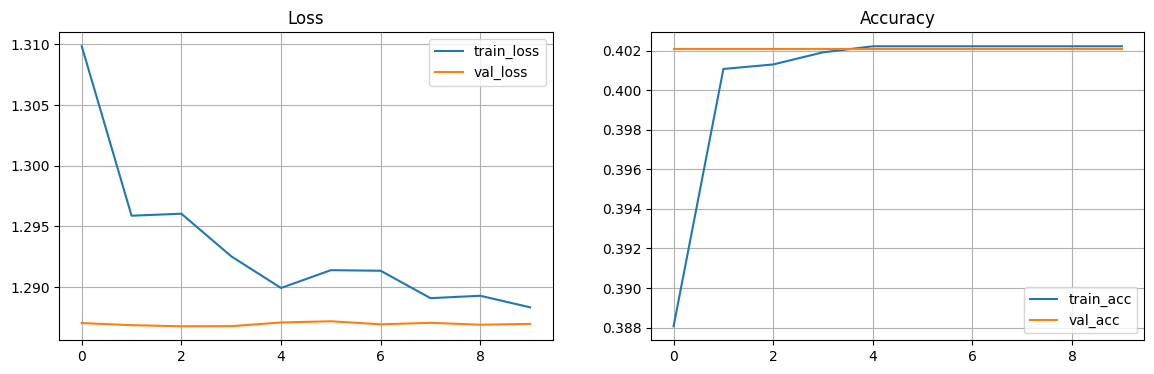

In [ ]:
# Plot train/val loss & accuracy
def plot_history(history):
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_title("Loss")
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(history.history['accuracy'], label='train_acc')
    ax[1].plot(history.history['val_accuracy'], label='val_acc')
    ax[1].set_title("Accuracy")
    ax[1].legend()
    ax[1].grid(True)
    plt.show()

plot_history(history)

In [ ]:
# Evaluate on validation set (print metrics)
val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=0)
print(f"Validation loss: {val_loss:.4f} | Validation accuracy: {val_acc:.4f}")

# Predictions and classification report
y_val_pred_proba = model.predict(X_val_pad, batch_size=128, verbose=0)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)

print("\nClassification Report (validation):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_, digits=4))

Validation loss: 1.2870 | Validation accuracy: 0.4021

Classification Report (validation):
              precision    recall  f1-score   support

      Change     0.0000    0.0000    0.0000       341
    Incident     0.4021    1.0000    0.5735      1314
     Problem     0.0000    0.0000    0.0000       680
     Request     0.0000    0.0000    0.0000       933

    accuracy                         0.4021      3268
   macro avg     0.1005    0.2500    0.1434      3268
weighted avg     0.1617    0.4021    0.2306      3268



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Show a few example predictions with input text, true label, predicted label, and confidence
def show_examples(n=10):
    idx = np.random.choice(len(X_val_pad), size=n, replace=False)
    for i in idx:
        txt = X_val[idx.tolist().index(i)] if False else X_val[i]  # fallback
        text = X_val[i]
        cleaned = clean_text(text)
        seq = tokenizer.texts_to_sequences([cleaned])
        pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
        proba = model.predict(pad, verbose=0)[0]
        pred = np.argmax(proba)
        conf = proba[pred]
        print("----")
        print("Text (truncated):", text[:350].replace('\n',' '))
        print("True:", le.inverse_transform([y_val[i]])[0], "| Pred:", le.inverse_transform([pred])[0], f"| Confidence: {conf:.3f}")
        print()

print("\nSample predictions from validation set:")
show_examples(10)


Sample predictions from validation set:
----
Text (truncated): Reported Connectivity Problem at Financial Institution. The financial organization encountered connectivity disruptions across various services, likely due to software conflicts or network failures. Initial troubleshooting steps involved rebooting devices and updating software, but the problem remains unresolved. Diagnostic analysis support is need
True: Incident | Pred: Incident | Confidence: 0.410

----
Text (truncated): Delay in Financial Data Access. Currently facing delays in investment analytics, potentially due to server overload.
True: Problem | Pred: Incident | Confidence: 0.410

----
Text (truncated): Incorporating Oracle Database 19c. I am reaching out to inquire about integrating Oracle Database 19c into a scalable SaaS project management platform. Could you offer guidance on the approach to successfully achieve this integration? I would also appreciate any documentation or support resources to facilitate a smo